In [69]:
from tvDatafeed import TvDatafeed, Interval

with open("../config/tradingview.key", "r", encoding="utf-8") as f:
    username, password = [line.strip() for line in f]

tv = TvDatafeed(username, password)

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stock_list = pd.read_excel('../data/stock_list.xlsx', index_col=0)

In [47]:
filtered_stocks = stock_list[(stock_list['country'] == 'United States') | (stock_list['country'] == 'South Korea')][['ticker','exchange']]

In [50]:
filtered_stocks

,ticker,exchange
no,,
1,CEG,NASDAQ
2,VST,NYSE
3,TLN,NASDAQ
4,SMR,NYSE
5,OKLO,NYSE
6,NNE,NASDAQ
7,NaN,NaN
8,NaN,NaN
10,GEV,NYSE


In [51]:
stock_tickers = {
    i : j for i, j in zip(filtered_stocks['ticker'], filtered_stocks['exchange'])
}

In [52]:
for ticker, exchange in stock_tickers.items() :
    print(ticker, exchange)

CEG NASDAQ
VST NYSE
TLN NASDAQ
SMR NYSE
OKLO NYSE
NNE NASDAQ
nan nan
GEV NYSE
052690 KRX
034020 KRX
083650 KRX
032820 KRX
044490 KRX
BWXT NYSE
CW NYSE
MIR NYSE
000720 KRX
375500 KRX
028260 KRX
FLR NYSE
LEU AMEX
ASPI NASDAQ
CCJ NYSE
UEC AMEX
DUK NYSE
SO NYSE
D NYSE
ETR NYSE
NRG NYSE
100840 KRX
WWD NASDAQ
HWM NYSE
CRS NYSE


In [72]:
import time

def get_data_from_tradingview(
        stock_tickers: dict,
        columns: str | list | None = None,
        interval=Interval.in_daily,
        n_bars: int = 2500,
        max_retries: int = 5
    ) -> pd.DataFrame:
    """
    TradingView에서 여러 종목의 가격 데이터를 수집합니다.

    Parameters
    ----------
    stock_tickers : dict
        {'TICKER': 'EXCHANGE'} 형태의 딕셔너리
        예: {'AAPL': 'NASDAQ', 'DJI': 'TVC'}
    columns : str | list | None, optional
        특정 컬럼만 선택해서 반환 ('close', ['open','close'] 등)
        None이면 전체 컬럼 반환
    interval : tradingview_ta.Interval
        데이터 주기 (기본값: 일간)
    n_bars : int
        불러올 데이터 개수 (기본값: 2500)
    max_retries : int
        각 종목당 최대 재시도 횟수 (기본값: 5)
    """

    price_data = {}

    for ticker, exchange in stock_tickers.items():
        if pd.isna(ticker) or str(ticker).strip() == "":
            print(f"🚫 ticker is empty : {exchange}")
            continue

        col_name = f"{exchange}:{ticker}"
        success = False

        for attempt in range(1, max_retries + 1):
            try:
                df = tv.get_hist(
                    symbol=ticker,
                    exchange=exchange,
                    interval=interval,
                    n_bars=n_bars
                )

                if df is None or df.empty:
                    raise ValueError("No data returned")

                df.index = pd.to_datetime(df.index.strftime("%Y-%m-%d"))

                # ✅ 컬럼 선택 처리
                if columns is None:
                    selected = df.copy()  # 전체 컬럼
                elif isinstance(columns, str):
                    selected = df[[columns]]
                else:  # list
                    selected = df[columns]

                # 컬럼 이름 변경
                selected.columns = (
                    [f"{col_name}:{col}" for col in selected.columns]
                    if len(selected.columns) > 1 else [col_name]
                )

                price_data[col_name] = selected
                print(f"✅ {col_name} completed ({len(df)} rows)")
                success = True
                break

            except Exception as e:
                print(f"⚠️ {col_name} attempt {attempt}/{max_retries} : {e}")
                time.sleep(2 * attempt)

        if not success:
            print(f"❌ failed to download stock : {col_name}")

    # 🔹 모든 데이터 병합
    if price_data:
        merged_df = pd.concat(price_data.values(), axis=1)
        return merged_df
    else:
        print("❌ no data collected")
        return pd.DataFrame()

In [73]:
price_data = get_data_from_tradingview(
    stock_tickers = stock_tickers,
    columns = 'close'
)

✅ NASDAQ:CEG completed (946 rows)
✅ NYSE:VST completed (2128 rows)
✅ NASDAQ:TLN completed (599 rows)
✅ NYSE:SMR completed (1225 rows)
✅ NYSE:OKLO completed (1053 rows)
✅ NASDAQ:NNE completed (368 rows)
🚫 ticker is empty : nan
✅ NYSE:GEV completed (397 rows)
✅ KRX:052690 completed (2500 rows)
✅ KRX:034020 completed (2500 rows)
✅ KRX:083650 completed (2500 rows)
✅ KRX:032820 completed (2500 rows)
✅ KRX:044490 completed (2500 rows)
✅ NYSE:BWXT completed (2500 rows)
✅ NYSE:CW completed (2500 rows)
✅ NYSE:MIR completed (1007 rows)
✅ KRX:000720 completed (2500 rows)
✅ KRX:375500 completed (1164 rows)
✅ KRX:028260 completed (2500 rows)
✅ NYSE:FLR completed (2500 rows)
✅ AMEX:LEU completed (2500 rows)
✅ NASDAQ:ASPI completed (741 rows)
✅ NYSE:CCJ completed (2500 rows)
✅ AMEX:UEC completed (2500 rows)
✅ NYSE:DUK completed (2500 rows)
✅ NYSE:SO completed (2500 rows)
✅ NYSE:D completed (2500 rows)
✅ NYSE:ETR completed (2500 rows)
✅ NYSE:NRG completed (2500 rows)
✅ KRX:100840 completed (2500 rows)

<Axes: xlabel='datetime'>

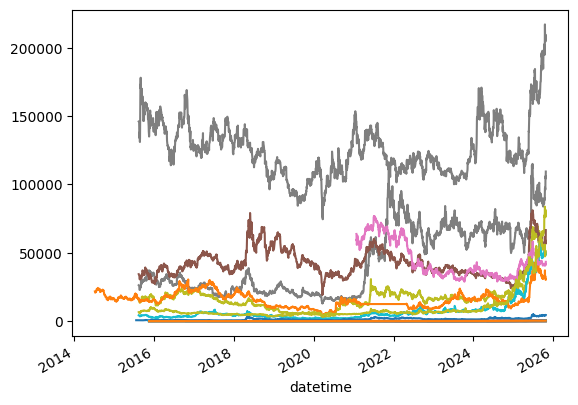

In [78]:
price_data.ffill().plot(legend = False)

In [85]:
index_tickers = {
    'SPX' : 'TVC',
    'IXIC' : 'TVC',
    'XAX' : 'TVC',
    'KOSPI' : 'KRX'
}

In [86]:
indices_data = get_data_from_tradingview(
    stock_tickers = index_tickers,
    columns = 'close'
)

✅ TVC:SPX completed (2500 rows)
✅ TVC:IXIC completed (2500 rows)
✅ TVC:XAX completed (2500 rows)
✅ KRX:KOSPI completed (2500 rows)


<Axes: xlabel='datetime'>

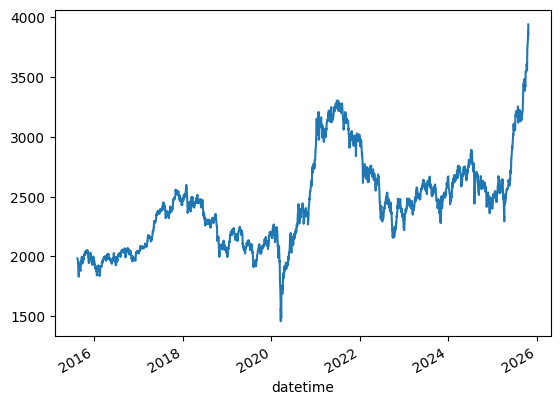

In [88]:
indices_data.ffill()['KRX:KOSPI'].plot()